<a href="https://colab.research.google.com/github/Dharren09/MicroscopyNets/blob/main/MaskRCNN_on_microscopy_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install orjson
!pip install lightning
!pip install torchmetrics

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn-v0_8-dark-palette')
import subprocess
from pathlib import Path
import os
import skimage
from PIL import Image
import torch
import shutil
import random
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision.datasets import ImageFolder
import xml.etree.ElementTree as ET
import json
import orjson
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import cv2
from typing import Dict, List, Tuple, Union
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from lightning.pytorch.callbacks import ModelCheckpoint, BackboneFinetuning
import pytest

import logging
logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [48]:
# Device configuration

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using '{device}'")

Using 'cuda'


In [49]:
subprocess.run(['unzip', '/content/drive/MyDrive/Colab Notebooks/Machine Learning Datasets/plasmodium-images.zip', '-d', '/content/working_directory'])

CompletedProcess(args=['unzip', '/content/drive/MyDrive/Colab Notebooks/Machine Learning Datasets/plasmodium-images.zip', '-d', '/content/working_directory'], returncode=1)

In [50]:
# directories within the dataset folder

DATA_DIR = Path('/content/working_directory')

print(os.listdir(DATA_DIR))

['TrainValData', 'README.txt', 'annotation', 'images']


In [51]:
# How many extensions are we dealing
IMAGES_DIR = DATA_DIR / 'images'

ext_map = {} # hash map to follow up and track our extensions

for image in IMAGES_DIR.glob('*'):
  ext = image.suffix
  if ext in ext_map:
    ext_map[ext] += 1
  else:
    ext_map[ext] = 1

ext_map

{'.jpg': 2703}

In [52]:
# Visualize some Images

def visualize_images(image_dir, n_images=12, n_cols=3, image_size=(1024, 768)):
  if not Path(image_dir).is_dir():
    raise ValueError("{} is either an invalid directory or does not exist".format(image_dir))

  image_paths = []
  with os.scandir(image_dir) as entries:
    for entry in entries:
      if entry.is_file():
        image_paths.append(entry.path)
        if len(image_paths) >= n_images:
          break

  # visualization logic
  rows = (len(image_paths) + n_cols - 1) // n_cols
  fig, ax = plt.subplots(rows, n_cols, figsize=(15, 5*rows))

  for idx, image_path in enumerate(image_paths):
    if not Path(image_path).is_file():
      raise ValueError("No image to display in the following {}".format(image_path))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # by default, CV generates BGR images
    image = cv2.resize(image, image_size)

    row = idx // n_cols
    col = idx % n_cols

    ax[row, col].imshow(image)
    ax[row, col].axis('off')

  # Deleting blank or empty axes
  for j in range(len(image_paths), rows * n_cols):
    fig.delaxes(ax[j // n_cols, ax % n_cols])

  plt.tight_layout()
  plt.show()

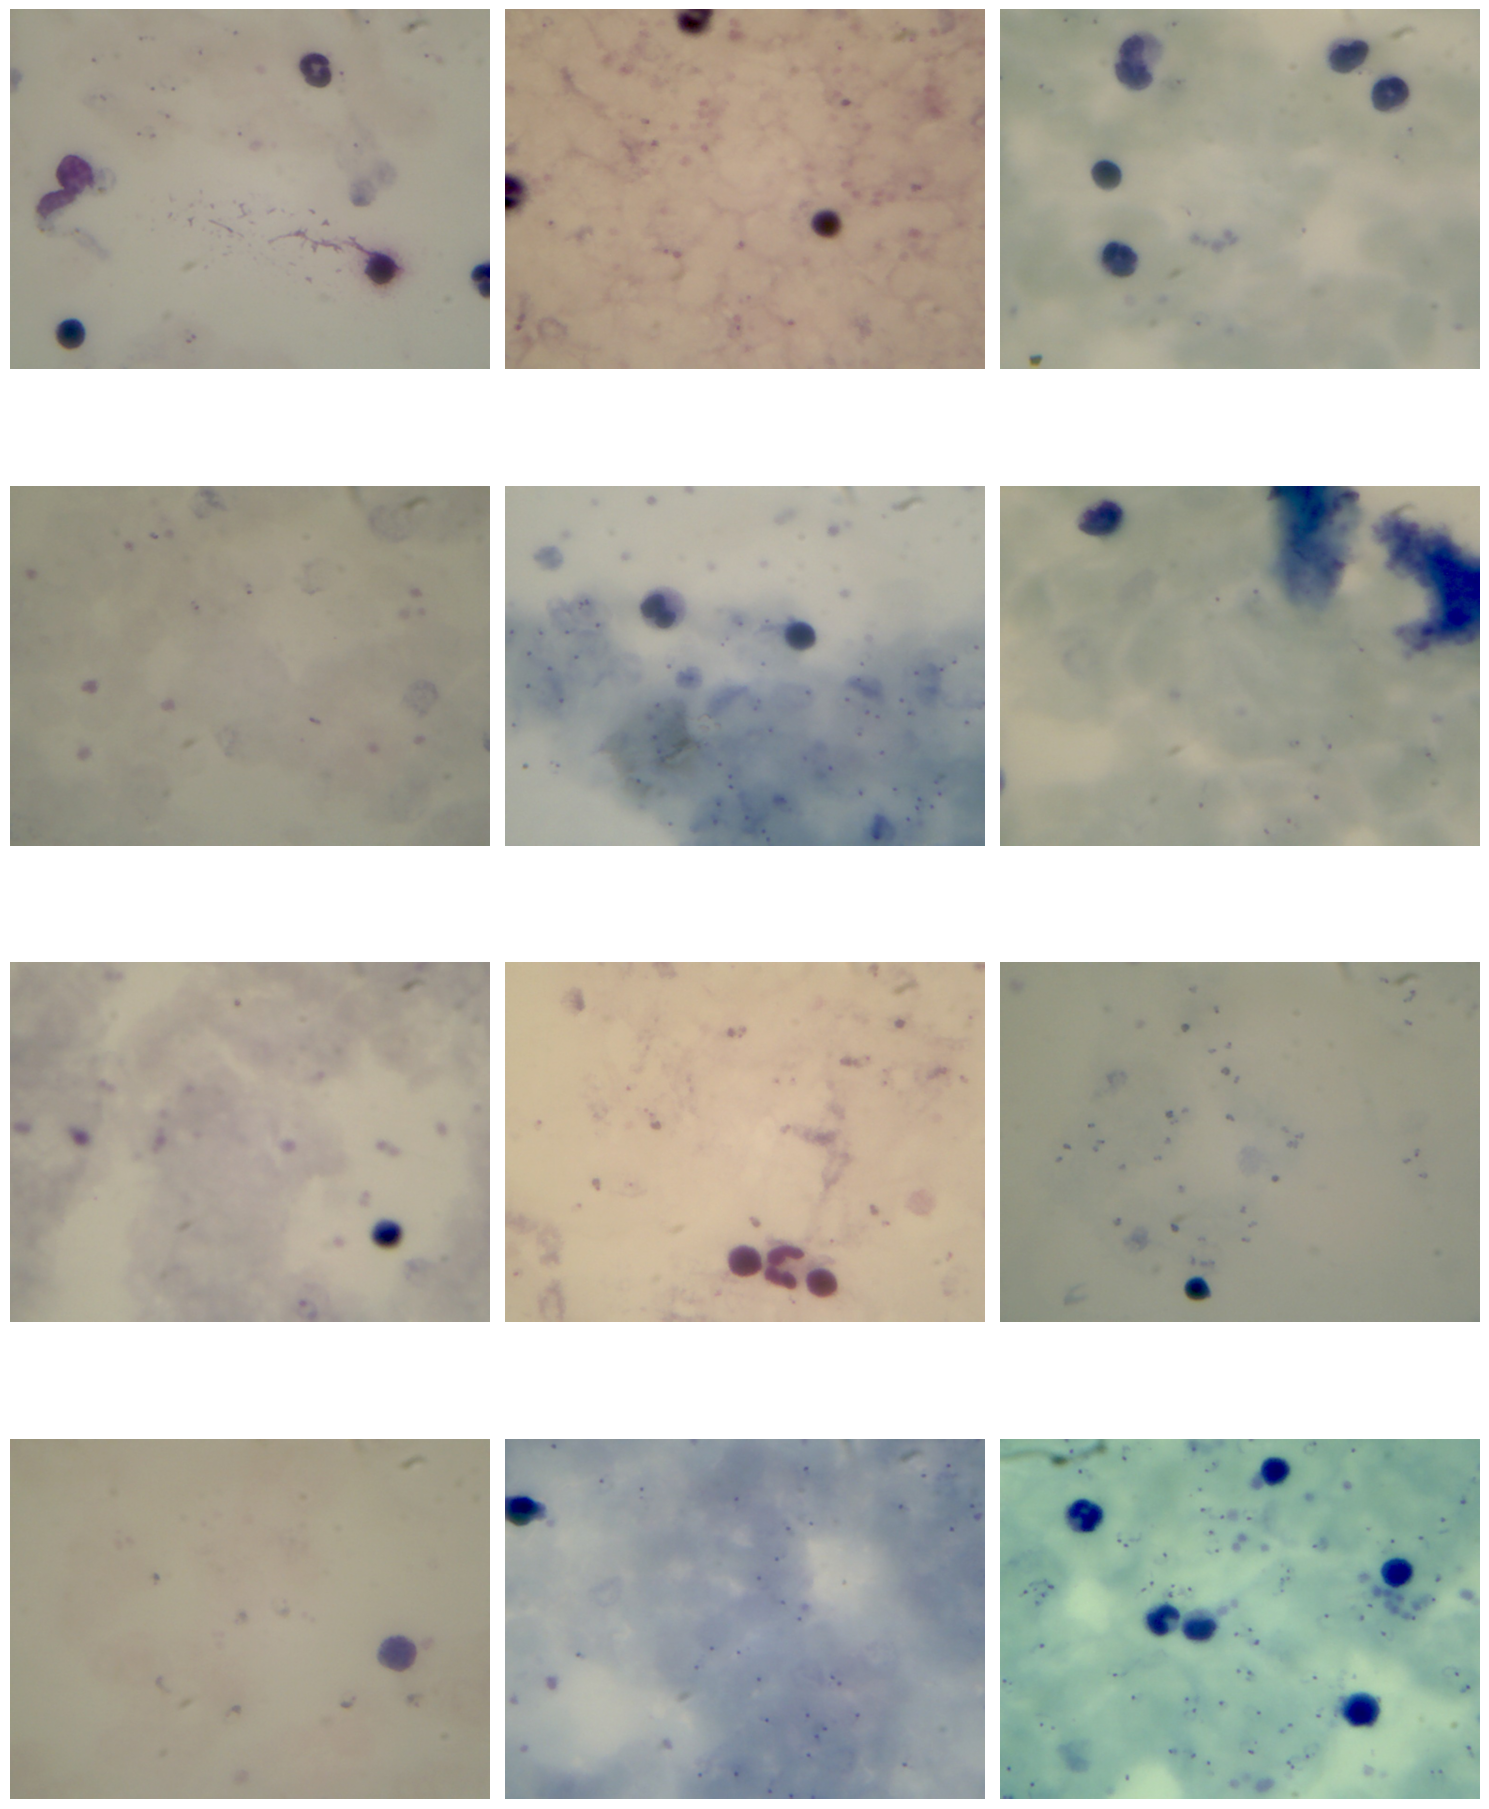

In [53]:
visualize_images(IMAGES_DIR, n_images=12)

# **Train-Validation data splitting**

In [54]:
class TrainValSplitter():
  def __init__(self, images_dir, annotations_dir, output_dir, train_size=0.8):
    super(TrainValSplitter, self).__init__()
    self.images_dir = images_dir
    self.annotations_dir = annotations_dir
    self.output_dir = output_dir
    self.train_size = train_size

  def get_pairs(self):
    image_files = {f.stem: f for f in self.images_dir.glob('*.jpg')} # or we could use just '*' given that i have only one format of images
    annotation_files = {f.stem: f for f in self.annotations_dir.glob('*.xml')}

    # collecting only images that have annotations, validation done based on basename (stem)
    pairs = [(image_files[name], annotation_files[name]) for name in image_files if name in annotation_files]
    return pairs

  def pair_split(self, pairs):
    train_pairs, val_pairs = train_test_split(pairs, train_size=self.train_size, random_state=1332)
    return train_pairs, val_pairs

  def copy_files(self, pairs, subset_name):
    images_output_dir = self.output_dir / subset_name / 'images'
    annotations_output_dir = self.output_dir / subset_name / 'annotations'

    images_output_dir.mkdir(parents=True, exist_ok=True)
    annotations_output_dir.mkdir(parents=True, exist_ok=True)

    for img_file, annot_file in pairs:
      shutil.copy(img_file, images_output_dir / img_file.name)
      shutil.copy(annot_file, annotations_output_dir / annot_file.name)

  def execute(self):
    pairs = self.get_pairs()
    train_pairs, val_pairs = self.pair_split(pairs)

    self.copy_files(train_pairs, 'train')
    self.copy_files(val_pairs, 'val')

    print(f"Training data: {len(train_pairs)} pairs")
    print(f"Validation data: {len(val_pairs)} pairs")
    print(f"Done moving {len(train_pairs) + len(val_pairs)} for 2 respective folders")

In [55]:
# file paths
IMAGES_DIR = DATA_DIR / 'images'
ANNOTATIONS_DIR = DATA_DIR / 'annotation'
OUTPUT_DIR = DATA_DIR / 'TrainValData'

# call
splitter = TrainValSplitter(images_dir=IMAGES_DIR, annotations_dir=ANNOTATIONS_DIR, output_dir=OUTPUT_DIR)
splitter.execute()

Training data: 2162 pairs
Validation data: 541 pairs
Done moving 2703 for 2 respective folders


In [56]:
# converting the xml files to a usable format like coco in my instance
# the various formats out there; - VOC
#                                - Pascal

class xmlToJSON():
  def __init__(self, xml_folder, image_folder, output_dir, normalize_bboxes=None):
    super(xmlToJSON, self).__init__()
    self.xml_folder = Path(xml_folder)
    self.image_folder = Path(image_folder)
    self.output_dir = Path(output_dir)
    self.normalize_bboxes = normalize_bboxes

  def xml_to_coco_format(self, xml_file, image_folder, image_id, normalize_bboxes=None):
    try:
      tree = ET.parse(xml_file)
      root = tree.getroot()
    except ET.ParseError as e:
      logging.error(f"Error parsing xml_file {xml_file}: {e}")
      return None

    coco_format = {
        'images' : [],
        'annotations': [],
        'categories': []
    }

    # image _details
    size_element = root.find('size')
    if size_element is None:
      logging.error(f"Can't find the 'size' branch and it's information in the {xml_file} file")
      return None

    width = int(root.find('size/width').text or 0)
    height = int(root.find('size/height').text or 0)
    depth = int(root.find('size/depth').text or 0)
    file_name = Path(xml_file).with_suffix('.jpg').name # replace xml with jpg

    # checking if corresponding image exists
    image_path = Path(image_folder) / file_name
    if not image_path.is_file():
      logging.warning(f"Warning: Image {file_name} is not available for {xml_file}: Skipping this file")
      return None

    # actions and their count per image
    actions = {}
    for action_tag in root.findall('object'):
      action_name = action_tag.find('action').text if action_tag is not None else 'unknown'
      if action_name in actions:
        actions[action_name] += 1
      else:
        actions[action_name] = 1

    for label, count in actions.items():
      coco_format['images'].append({
          'image': image_id,
          'width': width,
          'height': height,
          'depth': depth,
          'file_name': file_name,
          'label': label,
          f'{label} count': count
      })

    # category_mapping
    category_map = {}
    annotation_id = 0

    for obj in root.findall('object'):
      category_name = obj.find('name').text
      if category_name not in category_map:
        category_id = len(category_map) + 1
        category_map[category_name] = category_id
        coco_format['categories'].append({
            'id': category_id,
            'name': category_name
        })

      # actions depict organisms contained in the image
      action = obj.find('action').text

      # Determine if the object is part of a crowd
      truncated = int(obj.find('truncated').text)
      occluded = int(obj.find('occluded').text)
      is_crowd = 1 if truncated == 1 or occluded == 1 else 0

      # Bounding boxes
      bbox = obj.find('bndbox')

      xmin = float(bbox.find('xmin').text)
      ymin = float(bbox.find('ymin').text)
      xmax = float(bbox.find('xmax').text)
      ymax = float(bbox.find('ymax').text)

      bb_width = xmax - xmin
      bb_height = ymax - ymin

      # apply normalizations
      if normalize_bboxes:
        bounding_boxes = [xmin/width, ymin/height, bb_width/width, bb_height/height] # YOLO format
      else:
        bounding_boxes = [xmin, ymin, bb_width, bb_height] # COCO format

      # Check the segmented field
      # 0 for no segmentations and 1 for segmentations
      segmented = int(root.find('segmented').text)
      segmentation = []  # Default to empty if not segmented
      if segmented == 1:
        # Replace with actual segmentation extraction logic if available
        # Example: if you have polygon coordinates, add them to the segmentation list
        # segmentation = [[x1, y1, x2, y2, ..., xn, yn]]  # Example format
        pass  # Implement your logic here

      coco_format['annotations'].append({
          'annotation_id': annotation_id,
          'image_id': image_id,
          'category_id': category_map[category_name],
          'bounding_boxes': bounding_boxes,
          'area of bounding box': bb_width * bb_height,
          'is_crowd': is_crowd,
          'segmentation': segmentation  # This will be empty if segmented is 0
      })
      annotation_id += 1

    return coco_format

  def execute(self):

    coco_data = {
        'images': [],
        'categories': [],
        'annotations': []
    }

    image_id = 0

    for xml_file in self.xml_folder.glob('*.xml'):
      coco_format = self.xml_to_coco_format(xml_file, self.image_folder, image_id, self.normalize_bboxes)
      if coco_format:
        coco_data['images'].extend(coco_format['images'])
        coco_data['categories'].extend(coco_format['categories'])
        coco_data['annotations'].extend(coco_format['annotations'])
        image_id += 1

    # storing only unique categories
    unique_cats = {category['id']: category for category in coco_data['categories']}
    coco_data['categories'] = list(unique_cats.values())

    # file handling
    if self.output_dir.exists():
      print(f"'{self.output_dir} already exists")
    else:
      self.output_dir.parent.mkdir(parents=True, exist_ok=True)
      print(f"created '{self.output_dir}' successfully")

    with open(self.output_dir, 'w') as json_file:
      json.dump(coco_data, json_file, indent=4)

In [57]:
%%time

# convert to JSON

# Defining the file paths
TRAINVAL_DIR = DATA_DIR / 'TrainValData'
TRAIN_JSON = TRAINVAL_DIR / 'train.json'
VAL_JSON = TRAINVAL_DIR / 'validation.json'
TRAIN_IMAGES = TRAINVAL_DIR / 'train' / 'images'
VAL_IMAGES = TRAINVAL_DIR / 'val' / 'images'
TRAIN_ANNOTATIONS = TRAINVAL_DIR / 'train' / 'annotations' # /content/working_directory/TrainValData/train
VAL_ANNOTATIONS = TRAINVAL_DIR / 'val' / 'annotations'

CPU times: user 77 µs, sys: 0 ns, total: 77 µs
Wall time: 81.3 µs


In [58]:
%%time
# creating JSON files

xmlToJSON(xml_folder=TRAIN_ANNOTATIONS, image_folder=TRAIN_IMAGES, output_dir=TRAIN_JSON).execute()
xmlToJSON(xml_folder=VAL_ANNOTATIONS, image_folder=VAL_IMAGES, output_dir=VAL_JSON).execute()

'/content/working_directory/TrainValData/train.json already exists
'/content/working_directory/TrainValData/validation.json already exists
CPU times: user 3 s, sys: 180 ms, total: 3.18 s
Wall time: 3.74 s


In [59]:
# exploration

with open(VAL_JSON, 'rb') as v_file:
  val_coco_data = orjson.loads(v_file.read())
  for item in val_coco_data:
    print(json.dumps(item, indent=4))

"images"
"categories"
"annotations"


In [60]:
# images

for entry in val_coco_data['images']:
  print(json.dumps(entry, indent=4))

{
    "image": 0,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-2422.jpg",
    "label": "Trophozoite",
    "Trophozoite count": 8
}
{
    "image": 1,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-0040.jpg",
    "label": "Trophozoite",
    "Trophozoite count": 34
}
{
    "image": 2,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-0095.jpg",
    "label": "Trophozoite",
    "Trophozoite count": 19
}
{
    "image": 3,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-1587.jpg",
    "label": "Trophozoite",
    "Trophozoite count": 21
}
{
    "image": 4,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-2575.jpg",
    "label": "Trophozoite",
    "Trophozoite count": 22
}
{
    "image": 5,
    "width": 1024,
    "height": 768,
    "depth": 3,
    "file_name": "plasmodium-1393.jpg",
    "label": "Trophozoite",
    "Tropho

In [61]:
# annotations

for entry in val_coco_data['annotations']:
  print(json.dumps(entry, indent=4))

Streaming output truncated to the last 5000 lines.
    "segmentation": []
}
{
    "annotation_id": 2,
    "image_id": 527,
    "category_id": 1,
    "bounding_boxes": [
        766.7208,
        15.2022,
        50.0,
        50.00000000000001
    ],
    "area of bounding box": 2500.0000000000005,
    "is_crowd": 0,
    "segmentation": []
}
{
    "annotation_id": 3,
    "image_id": 527,
    "category_id": 1,
    "bounding_boxes": [
        817.2431,
        -3.2816,
        50.0,
        50.0
    ],
    "area of bounding box": 2500.0,
    "is_crowd": 0,
    "segmentation": []
}
{
    "annotation_id": 4,
    "image_id": 527,
    "category_id": 1,
    "bounding_boxes": [
        974.9711,
        62.0277,
        51.23230000000012,
        49.99999999999999
    ],
    "area of bounding box": 2561.6150000000057,
    "is_crowd": 0,
    "segmentation": []
}
{
    "annotation_id": 5,
    "image_id": 527,
    "category_id": 1,
    "bounding_boxes": [
        970.0421,
        124.8724,
      

In [62]:
for entry in val_coco_data['categories']:
  print(json.dumps(entry, indent=4))

{
    "id": 1,
    "name": "person"
}


In [63]:
# validating how many labels we have?

label_dict = defaultdict()

for entry in val_coco_data['images']:
  label = entry['label']
  if label in label_dict:
    label_dict[label] += 1
  else:
    label_dict[label] = 1

print(f"Classes : {label_dict.items()}")

Classes : dict_items([('Trophozoite', 471), ('Gamaetocyte', 6), ('Plasmodium', 3)])


In [64]:
labels_dict = defaultdict()
with open(TRAIN_JSON, 'rb') as t_file:
  train_coco_data = orjson.loads(t_file.read())
  for entry in train_coco_data['images']:
    label = entry['label']
    if label in labels_dict:
      labels_dict[label] += 1
    else:
      labels_dict[label] = 1

print(f"Classes : {labels_dict.items()}")

Classes : dict_items([('Trophozoite', 1912), ('Plasmodium', 10), ('Gamaetocyte', 18)])


In [65]:
# UTILITY FUNCTIONS
def calc_normalization_params(dataloader, device: callable=None, num_workers: int=4) -> Dict[str, torch.Tensor]:
  """
  Calculate custom normalization parameters
  """
  total_sum = torch.zeros(3, device=device)  # Initialize for RGB channels
  total_squared_sum = torch.zeros(3, device=device)  # Initialize for RGB channels
  total_count = 0
  CUSTOM_NORM_PARAMS = {}

  for images, targets in dataloader:
    images = images.to(device)  # moving images to a specified device
    batch_size = images.size(0)

    for channel in range(3):  # Loop over the channels
        sum_ = images[:, channel].sum()  # Sum for each channel
        sum_squared = (images[:, channel] ** 2).sum()  # Squared sum for each channel
        total_sum[channel] += sum_
        total_squared_sum[channel] += sum_squared

    total_count += batch_size * images.size(2) * images.size(3)  # Total number of pixels in the batch

    means = total_sum / total_count
    stds = (total_squared_sum / total_count - means ** 2).sqrt()  # std = sqrt(E[X^2] - (E[X])^2)

    CUSTOM_NORM_PARAMS['means'] = means
    CUSTOM_NORM_PARAMS['stds'] = stds

    return CUSTOM_NORM_PARAMS  # Return calculated normalization parameters

# utility function
def pad_collate_fn(batch):
  """
  Since the each image contains a different number of bounding boxes, given the different numbers of features.
  the collate_fn_map is responsible for stacking feature tensors into a batch in the DataLoader but can't if the tensors are of varying sizes.
  Therefore; to ensure compatibility, we are padding (-1) -> invalid at the extremes to ensures all bboxes are of the same sizes.
  """
  max_bboxes = max([target['bbox'].size(0) for _, target in batch])
  padded_batch = []

  for image, target in batch:
    bboxes = target['bbox']
    num_bboxes = bboxes.size(0)

    if num_bboxes < max_bboxes:
      padded_bboxes = torch.cat([bboxes, torch.zeros((max_bboxes - num_bboxes, 4), dtype=torch.float32)], dim=0)
      target['bbox'] = padded_bboxes
    padded_batch.append((image, target))

  return default_collate(padded_batch)

In [66]:
class PlasmodiumDataset(Dataset):
    def __init__(self, json_file: Union[str, Path], image_folder: Union[str, Path],
                 custom_image_size: Tuple[int] = None, patch_size: Tuple[int] = None,
                 transform: callable = None) -> None:
        """
        Initialize the Plasmodium Dataset.

        Parameters:
            - json_file: Path to the JSON file containing annotations.
            - image_folder: Path to the image folder containing images.
            - custom_image_size: Optional tuple of image size to which images can be resized.
            - patch_size: Optional tuple representing the size of the patches.
            - transform: Optional transform to be applied to the images.
        """
        self.image_folder = Path(image_folder)
        self.custom_image_size = custom_image_size
        self.patch_size = patch_size
        self.transform = transform

        # Load JSON data
        self.coco_data = self._load_json(json_file)
        self.image_dict = self._populate_image_dict()
        self.image_ids = list(self.image_dict.keys())
        self.encoder = OneHotEncoder(sparse_output=False)
        unique_labels = list(set(img_info['label'] for img_info in self.image_dict.values()))
        self.encoded_labels = self.encoder.fit_transform(np.array(unique_labels).reshape(-1, 1))

    def _load_json(self, json_file: Union[str, Path]) -> dict:
        """Load and return the JSON data."""
        try:
            with open(json_file, 'rb') as file:
                return orjson.loads(file.read())
        except (FileNotFoundError, json.JSONDecodeError) as e:
            logging.error(f"Error loading JSON file: {e}")
            raise

    def _populate_image_dict(self) -> defaultdict:
        """Populate the image dictionary with image information."""
        image_dict = defaultdict(lambda: {
            'label': None, 'image_name': None, 'image_size': (0, 0),
            'bboxes': [], 'area_of_bboxes': []
        })
        for img in self.coco_data['images']:
            image_id = img['image']
            image_dict[image_id].update({
                'label': img['label'],
                'image_name': img['file_name'],
                'image_size': (img['width'], img['height'])
            })

        for ann in self.coco_data['annotations']:
            image_id = ann['image_id']
            if image_id in image_dict:
                image_dict[image_id]['bboxes'].append(ann['bounding_boxes'])
                image_dict[image_id]['area_of_bboxes'].append(ann['area of bounding box'])

        return image_dict

    def __len__(self) -> int:
        """Get the length of the dataset."""
        return len(self.image_ids)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, dict]:
        """Get an item from the dataset."""
        img_id = self.image_ids[idx]
        img_info = self.image_dict[img_id]
        image_path = self.image_folder / img_info['image_name']

        target = self._initialize_target(img_info)
        image = self._load_image(image_path, img_info['image_size'])

        # Resize the image if a custom size is provided
        if self.custom_image_size:
            image = cv2.resize(image, self.custom_image_size, interpolation=cv2.INTER_LINEAR)

        # Apply transformations if provided
        if self.transform:
            transformed = self.transform(image=image, bbox=target['bbox'], class_label=target['label'])
            image = transformed['image']
            target['bbox'] = transformed['bbox']
            target['label'] = transformed['class_label']

        return torch.tensor(image).permute(2, 0, 1), target  # Convert to CHW format

    def _initialize_target(self, img_info) -> dict:
        """Initialize the target dictionary with default values."""
        return {
            'label': torch.zeros(len(self.encoder.categories_[0]), dtype=torch.float32),
            'bbox': torch.zeros((0, 4), dtype=torch.float32),
            'area_of_bbox': torch.zeros((0,), dtype=torch.float32),
            'masks': torch.zeros((0, *img_info['image_size']), dtype=torch.float32)
        }

    def _load_image(self, image_path: Path, image_size: Tuple[int]) -> np.ndarray:
        """Load an image from the specified path, returning a placeholder if necessary."""
        if not image_path.is_file():
            logging.error(f"Invalid image path: {image_path}. Loading Placeholder")
            return self._create_placeholder_image(image_size)

        image = cv2.imread(str(image_path))
        if image is None:
            logging.error(f"Image: {image_path} is faulty, returning a Placeholder instead")
            return self._create_placeholder_image(image_size)

        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def _create_placeholder_image(self, image_size: Tuple[int]) -> np.ndarray:
        """Create a placeholder image of the specified size."""
        return np.zeros((self.custom_image_size[1], self.custom_image_size[0], 3),
                        dtype=np.uint8) if self.custom_image_size else np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)

    def generate_masks(self, bounding_boxes) -> np.ndarray:
        """Generate masks for the given bounding boxes."""
        num_instances = len(bounding_boxes)
        masks = np.zeros((num_instances, *self.image_dict[next(iter(self.image_ids))]['image_size']), dtype=np.uint8)

        for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
            masks[i, y1:y2, x1:x2] = 1  # Generating masks for the indexed bbox

        return masks
    def classnames_(self) -> List[str]:
      """Returns the uniques classnames of the Dataset"""
      return self.encoder.categories_[0].tolist()

    def inverse_transform(self):
      """This function transforms back the encoded labels to original format"""
      return self.encoder.inverse_transform(self.encoded_labels).reshape(1,-1)[0]

    def extract_patches(self, image: np.ndarray, patch_size: Tuple[int]) -> List[np.ndarray]:
      """Splits the image into patches

      Parameters:
        image: np.ndarray from which the patches shall be extracted
        patch_size: Tuple consisting of the sizes of the patches.

      Return:
        A list of patches in np.ndarray format
      """
      pass

    def reassemble_patches(self, patches: List[np.ndarray]) -> np.ndarray:
      """Re-assembles the patches to form back the original image, This is useful in later stages of
      evaluation and inferencing, as predicted features from the patches are summed up to generate,
      a more accurate prediction
      """
      pass

In [67]:
class PlasmodiumDataModule(L.LightningDataModule):
    def __init__(self, train_json: Union[str, Path], val_json: Union[str, Path],
                 train_images: Union[str, Path], val_images: Union[str, Path],
                 batch_size: int = 32, num_workers: int = 2,
                 means: Union[List[float], Tuple[float, ...]] = (0.485, 0.456, 0.406),
                 stds: Union[List[float], Tuple[float, ...]] = (0.229, 0.224, 0.225)):
        """
        Initialize the Plasmodium DataModule.

        Parameters:
            - train_json: Path to the training JSON file containing annotations.
            - val_json: Path to the validation JSON file containing annotations.
            - train_images: Path to the training image folder.
            - val_images: Path to the validation image folder.
            - batch_size: The batch size for dataloaders.
            - num_workers: Number of workers for data loading.
            - means: Mean values for normalization.
            - stds: Standard deviation values for normalization.
        """
        super().__init__()
        self.train_json = train_json
        self.val_json = val_json
        self.train_images = train_images
        self.val_images = val_images
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.means = means
        self.stds = stds

        self.train_transforms, self.val_transforms = self.augmentation()

    def augmentation(self):
        """Define the augmentation strategies for training and validation."""
        train_transforms = A.Compose([
            A.Rotate(limit=90, p=0.5),
            A.RandomScale(scale_limit=0.2, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            A.ElasticTransform(p=0.5),
            A.Blur(blur_limit=3, p=0.3),
            A.Resize(768, 768),
            A.Normalize(mean=self.means, std=self.stds),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='coco', min_area=2500, min_visibility=0.3, label_fields='class_labels'))

        val_transforms = A.Compose([
            A.Resize(768, 768),
            A.Normalize(mean=self.means, std=self.stds),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='coco', min_area=2500, min_visibility=0.3, label_fields='class_labels'))

        return train_transforms, val_transforms

    def get_loaders(self, is_training: bool = True) -> DataLoader:
        """
        Get the training or validation dataloader.

        Parameters:
            is_training: If True, return the training dataloader; otherwise, return the validation dataloader.

        Returns:
            The training or validation dataloader.
        """
        if is_training:
            train_dataset = PlasmodiumDataset(json_file=self.train_json, image_folder=self.train_images,
                                              transform=self.train_transforms)
            return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,
                              num_workers=self.num_workers)
        else:
            val_dataset = PlasmodiumDataset(json_file=self.val_json, image_folder=self.val_images,
                                            transform=self.val_transforms)
            return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False,
                              num_workers=self.num_workers)

In [68]:
# Training Loaders

trainLoaders = PlasmodiumDataModule(train_json=TRAIN_JSON, val_json=VAL_JSON, train_images=TRAIN_IMAGES, val_images=VAL_IMAGES,
                                    num_workers=4).get_loaders(is_training=True)

valLoaders = PlasmodiumDataModule(train_json=TRAIN_JSON, val_json=VAL_JSON, train_images=TRAIN_IMAGES, val_images=VAL_IMAGES,
                                    num_workers=4).get_loaders(is_training=False)

## Model Setup⚓

## **Loss Functions for Mask R-CNN**

1. **Classification Loss (L_cls):**
   * This loss function is typically a cross-entropy loss that measures the difference between the predicted class probabilities and the true class labels for the detection objects.

2. **Bounding Box Regression Loss (L_box):**
   * This loss is usually a smooth L1 loss (also called Huber loss) that calculates the difference between the predicted bounding box coordinates and the ground truth bounding box coordinates. It helps in refining the bound boxes around detected objects.

3. **Mask Segmentation Loss (L_mask):**
   * For the mark predictions, binary cross-entropy loss is commonly used. This loss is applied per pixel for each object mask, where the model learns to predict binary mask for each detected object instance.



In [76]:
from torchvision.models.detection import MaskRCNN, maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.segmentation import MeanIoU

class MicroscopyNets_v1(L.LightningModule):
  def __init__(self, num_classes: int = None, learning_rate: float = 1e-4):
    super(MicroscopyNets_v1, self).__init__()
    self.num_classes = num_classes
    self.model = self._create_model(self.num_classes)
    self.lr = learning_rate
    self.mean_ap = MeanAveragePrecision(iou_type='bbox')
    self.mean_iou = MeanIoU(num_classes=num_classes, per_class=True)

  def _create_model(self, num_classes: int) -> MaskRCNN:
    # Initialize the Mask RCNN model
    # NOTE: You can either normalize the data in preprocessing stage or within the model initiation
    # TODO: introducing an RPNHead -> Region proposal network

    # This is an improved Mask R-CNN model with a ResNet-50-FPN backbone from the
    # `Benchmarking Detection Transfer Learning with ViTs` <https://arxiv.org/abs/2111.11429>`
    # source code <https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py>
    # Loads the pretrained model with ResNets50 weights
    model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT', pretrained=True,
                                     trainable_backbone_layers=3, num_classes=self.num_classes)

    # Configure the anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((8, 16, 32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 1.5, 2.0),)
    )

    # MASK R-CNNs parameters that can be custom tunned for better performance

    # out channels of the resnet50 last layer
    out_channels = model.backbone.out_channels

    # set the abchor generator to the rpn module
    model.rpn.anchor_generator = anchor_generator

    # set the min_size parameter
    model.rpn.min_size = 512

    # max number of proposals before Non-Max suppression
    model.rpn.pre_nms_top_n = 1000

    # number of proposal after NMS
    model.rpn.post_nms_top_n = 100

    # IoU threshold for nms
    model.rpn.nms_threshold = 0.7

    # max number of bounding box detections per image
    model.roi_heads.box_detections_per_img = 50

    # max number of masks detected per image
    model.roi_heads.mask_detections_per_img = 50

    # number of classes
    model.num_classes = self.num_classes

    return model

  def forward(self, images: torch.tensor):
    # check if image is a tensor
    if not isinstance(image, torch.Tensor):
      raise TypeError(f"Expected images of type torch.Tensor but got {type(images)} instead")

    # confirm if the image has 4 dimensions
    if images.ndim != 4:
      raise ValueError(f"Expected image shape (batch_size, channels, width, height) but got {images.shape} instead")

    # forward pass through the model
    return self.model(images)

  def training_step(self, batch, batch_idx):
    images, targets = batch

    # Validate inputs
    self.validate_inputs(images, targets)

    loss_dict = self.model(images, targets)
    # sum of all the 3 losses
    total_train_loss = sum(loss for loss in loss_dict.values())

    # Log individual loss components
    for loss_name, loss_value in loss_dict.items():
        self.log(f"train_{loss_name}", loss_value, on_step=True, on_epoch=True)

    self.log("train_loss", total_train_loss, on_step=True, on_epoch=True)

    return total_train_loss

  def validation_step(self, batch, batch_idx):
    images, targets = batch

    # Validate inputs
    self.validate_inputs(images, targets)

    y_hat = self.model(images)

    # compute MAP
    self.mean_ap(y_hat, targets)
    map_val = self.mean_ap.compute()
    self.log("val_MAP", map_val)

    # Compute mean IOU
    pred_masks = y_hat['masks'].squeeze(1) # remove extra dimensions
    target_masks = targets['masks']

    iou = self.mean_iou(pred_masks, target_masks)
    self.mean_iou.update(iou)
    masks_mIOU = self.mean_iou.compute()
    self.log("masks_miou", masks_mIOU) # Log the scalar value

    return {
        "Mean Precision Area": map_val,
        "Masks - Mean Intersection over Union": masks_mIOU
    }

  def predict_step(self, batch, batch_idx):
    images, targets = batch
    pred = self.model(images)

    return pred

  def validation_epoch_end(self, y_hat):
    self.mean_ap.reset()
    self.mean_iou.reset()

  def configure_optimizers(self):
    optimizer1 = Adam(params=self.parameters(), lr=config["training"]["learning_rate"], weight_decay=config["training"]["weight_decay"])
    optimizer2 = SGD(params=self.parameters(), lr=config["training"]["learning_rate"], momentum=config["training"]["momentum"],
                     weight_decay=config["training"]["weight_decay"])
    scheduler1 = ReduceLROnPlateau(optimizer=optimizer1, patience=config["training"]["patience"], mode='min')
    scheduler2 = MultiStepLR(optimizer=optimizer2)

    return (
        {
            "optimizer": optimizer1,
            "lr_scheduler": {
                "scheduler": scheduler1,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        },

        {"optimizer": optimizer2,
         "lr_scheduler": {
             "scheduler": scheduler2,
             "monitor": "val_loss",
             "interval": "epoch",
             "frequency": 1,
         }
        }
    )

  def validate_inputs(self, images: torch.Tensor, targets: dict):
    """
    Validate the inputs for the validation step.

    Parameters:
        images (torch.Tensor): The input images.
        targets (dict): The target annotations.

    Raises:
        TypeError: If the types of inputs are incorrect.
        ValueError: If the shapes of inputs are incorrect.
        KeyError: If required keys are missing in targets.
    """
    # Check if images are a tensor
    if not isinstance(images, torch.Tensor):
        raise TypeError(f"Expected images type is torch.Tensor, but got {type(images)} instead")

    # Check the shape of the input tensor
    if images.ndim != 4:
        raise ValueError(f"Expected images shape (batch_size, channels, height, width), but got {images.shape} instead")

    # Check if targets are a dictionary
    if not isinstance(targets, dict):
        raise TypeError(f"Expected targets type is dict, but got {type(targets)} instead")

    # Ensure that targets contain the required keys
    required_keys = ['bbox', 'label', 'masks', 'area_of_bbox']
    for key in required_keys:
        if key not in targets:
            raise KeyError(f"Missing required key '{key}' in targets")

    # Check if the masks are tensors
    if not isinstance(targets['masks'], torch.Tensor):
        raise TypeError(f"Expected targets['masks'] type is torch.Tensor, but got {type(targets['masks'])} instead")

    # Check the shape of target masks
    if targets['masks'].ndim != 4:
        raise ValueError(f"Expected target masks shape (batch_size, num_classes, height, width), but got {targets['masks'].shape} instead")

    # Additional checks will be added needed

In [74]:
# Configuration Dictionary
config = {
    "model": {
        "num_classes": 4,  # 3 feature classes + background
    },
    "training": {
        "learning_rate": 1e-4,
        "weight_decay": 0.009,
        "momentum": 0.9,
        "patience": 5,
    },
    "logger": {
        "type": "TensorBoardLogger",
        "log_dir": "logs/",
        "name": "microscopyNets_v1",
    },
}

In [77]:
# Initialize the trainer, model
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints/',
    filename='microscopyNets_v1-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,  # Save the top 3 models based on val_loss
)

# Backbone finetuning - using Vanilla
multiplicative =  lambda epoch: 1.5
backboneft = BackboneFinetuning(10, multiplicative)

trainer = Trainer(max_epochs=10,
                  devices=1,
                  accelerator='gpu' if device== 'cuda' else 'cpu',
                  logger=TensorBoardLogger(config["logger"]["log_dir"], name=config["logger"]["name"]),
                  log_every_n_steps=10,
                  check_val_every_n_epoch=4,
                  callbacks=[checkpoint_callback, backboneft])

microscopyNets_v1 = MicroscopyNets_v1(num_classes=config["model"]["num_classes"], learning_rate=config["training"]["learning_rate"])
trainer.fit(microscopyNets_v1, trainLoaders, valLoaders)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


ValueError: The parameter 'num_classes' expected value 91 but got 4 instead.

In [ ]:
maskrcnn_resnet50_fpn_v2?